In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.WGAN_model.WPGAN import WPGAN
from models.WGAN_model.WPGAN_GP import WPGAN_GP
from models.WGAN_model.config import *

import torch
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

In [32]:
dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel', conditions_path=conditions_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
Music_WPGAN = WPGAN_GP(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    loss=loss,
    batch_size=batch_size,
    gpu=gpu,
    depths=depths, 
    negative_slope=negative_slope,
    fade_in_percentage=fade_in_percentage,
    save_interval=save_interval,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    epsilon_D=epsilon_D,
    gen_type=get_type,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
    gen_output_dim=gen_output_dim,
    c=c,
    n_critic=n_critic,
    lambda_gp=lambda_gp,
    acgan=acgan,
    feature_size=feature_size,
    features_keys_order = features_keys_order
)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
Music_WPGAN.train(dataloader=dataloader)

Resolution 0 - Epoch 1/200 - D Loss: 9.92378044128418 - G Loss: 0.000714000896550715
Resolution 0 - Epoch 2/200 - D Loss: 9.782379150390625 - G Loss: 0.0029892437160015106
Resolution 0 - Epoch 3/200 - D Loss: 9.56540584564209 - G Loss: 0.008881504647433758
Resolution 0 - Epoch 4/200 - D Loss: 9.225152969360352 - G Loss: 0.03084489330649376
Resolution 0 - Epoch 5/200 - D Loss: 8.589960098266602 - G Loss: 0.12239399552345276
Resolution 0 - Epoch 6/200 - D Loss: 7.317808628082275 - G Loss: 0.5292881727218628
Resolution 0 - Epoch 7/200 - D Loss: 3.75673508644104 - G Loss: 1.6453094482421875
Resolution 0 - Epoch 8/200 - D Loss: -0.8366309404373169 - G Loss: 3.3818230628967285
Resolution 0 - Epoch 9/200 - D Loss: -4.966864109039307 - G Loss: 5.135870456695557
Resolution 0 - Epoch 10/200 - D Loss: -5.532403945922852 - G Loss: 5.754619121551514
Resolution 0 - Epoch 11/200 - D Loss: -5.973507404327393 - G Loss: 4.6817827224731445
Resolution 0 - Epoch 12/200 - D Loss: -5.593203067779541 - G Loss

In [ ]:
# Music_WPGAN.add_new_block(new_depth=256)
# Music_WPGAN.add_new_block(new_depth=128)
# Music_WPGAN.add_new_block(new_depth=64)
# Music_WPGAN.add_new_block(new_depth=32)
# Music_WPGAN.add_new_block(new_depth=16)

In [ ]:
# epochs, resolution = Music_WPGAN.load_checkpoint("../src/models/WGAN_model/checkpoints/PGAN_checkpoint_res5_epoch45.pth")
# epochs, resolution = Music_WPGAN.load_checkpoint("../src/models/WGAN_model/checkpoints/GIT_checkpoint_res5_epoch365.pth")

In [ ]:
# checkpoint_path = "../src/models/WGAN_model/checkpoints/PGAN_checkpoint_res5_epoch5.pth"
# Music_WPGAN.train(dataloader=dataloader, checkpoint_path=checkpoint_path)

In [ ]:
Music_WPGAN.close_all_writers()

In [ ]:
# Music_WPGAN.save_full_model("WPGAN-GP-acgan-test-set")

In [ ]:
Music_WPGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots()

    S_dB = librosa.amplitude_to_db(spectrogram, ref=np.min)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='WGAN-GP generated mel-spectrogram')

In [ ]:
bass_feature_vector = torch.zeros(1, 11)
keyboard_feature_vector = torch.zeros(1, 11)
bass_indices = [0]
keyboard_indices = [4]
bass_feature_vector[0, bass_indices] = 1
keyboard_feature_vector[0, keyboard_indices] = 1

In [ ]:
def generate_spectrogram():

    bass_feature_vector = torch.zeros(1, 11)
    keyboard_feature_vector = torch.zeros(1, 11)
    bass_indices = [0]
    keyboard_indices = [4]
    bass_feature_vector[0, bass_indices] = 1
    keyboard_feature_vector[0, keyboard_indices] = 1

    bass_feature_vector = bass_feature_vector.view(1, 11, 1, 1).to(Music_WPGAN.device)
    keyboard_feature_vector = keyboard_feature_vector.view(1, 11, 1, 1).to(Music_WPGAN.device)

    z = torch.randn(1, Music_WPGAN.latent_dim, 1, 1).to(Music_WPGAN.device)
    if Music_WPGAN.acgan:
        random_feature_vector = Music_WPGAN.classification_criterion.create_random_feature_vectors(b_size=1)
        random_feature_vector = random_feature_vector.view(1, -1, 1, 1).to(Music_WPGAN.device)
        z = torch.cat((z, random_feature_vector), dim=1)
        # z = torch.cat((z, bass_feature_vector), dim=1)
    generated_spectrogram = Music_WPGAN.generator(z)

    spectrogram = generated_spectrogram.cpu().detach()
    spectrogram = spectrogram.squeeze()

    return spectrogram

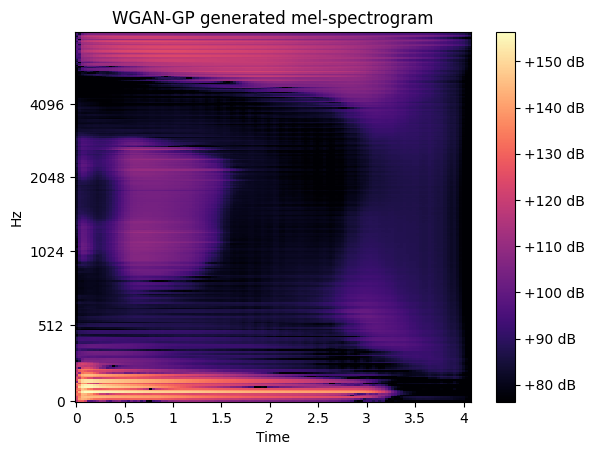

In [ ]:
spectrogram = generate_spectrogram()
plot_spectrogram(spectrogram)

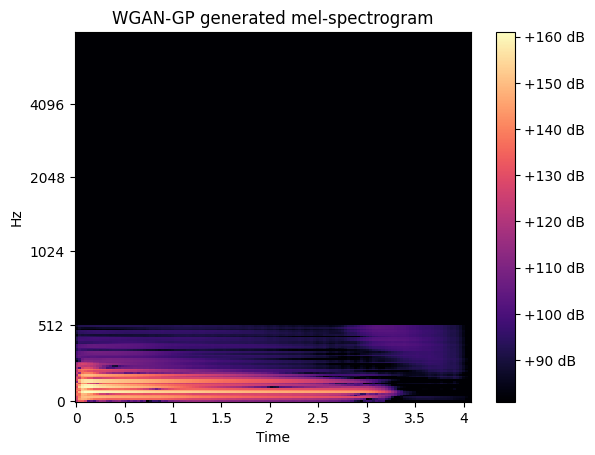

In [ ]:
max_freq = 1024
mel_max = librosa.hz_to_mel(max_freq)
n_mels = spectrogram.shape[0]
mel_freqs = librosa.mel_frequencies(n_mels=n_mels, fmax=8000)

high_freq_mask = mel_freqs > 512

for i in range(spectrogram.shape[1]):
    spectrogram[high_freq_mask, i] = 0

plot_spectrogram(spectrogram)

In [ ]:
audio = dataset.pipeline.post_process(audio=spectrogram)

path = '../models/generated_samples/'
file_name = 'WPGAN_generated_audio19.wav'

sf.write(path + file_name, data=audio, samplerate=16000, subtype='PCM_24')